<a href="https://colab.research.google.com/github/Saponjyan/CV/blob/main/diffusers/stable_diffusion_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from diffusers import StableDiffusionPipeline
# import torch

# model_id = "dreamlike-art/dreamlike-photoreal-2.0"
# pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
# pipe = pipe.to("cuda")

# prompt = "cat"
# # image = pipe(prompt).images[0]

# media.show_images(pipe(prompt).images)
# # image.save("./result.jpg")

In [ ]:
# %pip install --quiet --upgrade diffusers transformers accelerate mediapy triton scipy ftfy spacy==3.4.4
%pip install --quiet --upgrade diffusers transformers accelerate mediapy triton scipy ftfy spacy


In [ ]:
# The xformers package is mandatory to be able to create several 768x768 images.
# %pip install -q xformers==0.0.16rc425
%pip install -q xformers

In [ ]:
# model_id = "stabilityai/stable-diffusion-2-1-base"
# model_id = "stabilityai/stable-diffusion-2-1"
model_id = "dreamlike-art/dreamlike-photoreal-2.0"



In [ ]:
# EulerAncestralDiscreteScheduler
# В случае Маск-Каратель, на 50-м шаге начинает проявляться изображение, которое мы четко видим на шаге 100. Этот scheduler создает довольно кинематографичные результаты, особенно второй и третий сверху, но на двух из четырех толком не видно лица.
#######################################################
# DDIMScheduler
# Результаты сети с этим scheduler вообще не отражают сути запроса. В первой четверке, на четвертом изображении на шаге 100, что-то похожее на гуманоида, но и то отдаленно. Стоит также отметить, что к сотому шагу, очистка изображения от шума, кажется, еще не завершилась.

# UPDATE:
# Если использовать дефолтный DDIMScheduler, инициализированный с помощью from_config, то мы увидим результаты, не соответствующие запросу, как показано выше. Но если создавать планировщик явно, используя параметры из этого обсуждения (https://github.com/huggingface/diffusers/issues/706),
# то результаты будут гораздо ближе, к тому, что мы видим при других планировщиках. Спасибо за бдительность: @trix
# change this for DDIMScheduler

# scheduler = sched_class.from_config(config)
# # to this
# scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
#####################################################################################
# DDPMScheduler
# В этом плане DDPMScheduler также показывает себя похожим образом, на сотом шаге нет результата, на котором отчетливо различим результат запроса. Касаемо этого алгоритма стоит отметить, что он используется при обучении Stable Diffusion и в этом процессе количество шагов выше на порядок. Поэтому мы и не наблюдаем картинок на сотом шаге, а только лишь шум.
###############################################################
# Другие подходы
# Далее идут четыре алгоритма, которые производят крайне похожие результаты при одинаковых начальных данных. На всех четырех четверках, для обоих запросов, мы видим похожие изображения, различимые, при детальном рассмотрении.

# DPMSolverMultistepScheduler почти не отличим от DPMSolverSinglestepScheduler. LMSDiscreteScheduler явно имеет иную структуру шума на ранних этапах. А PNDMScheduler отказался вызывать callback с сохранением изображения на первом шаге денойзинга.



In [ ]:
from diffusers import PNDMScheduler, DDIMScheduler, LMSDiscreteScheduler, EulerDiscreteScheduler, DPMSolverMultistepScheduler

scheduler = None
# scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
scheduler = LMSDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")

In [ ]:

import mediapy as media
import torch
from diffusers import StableDiffusionPipeline
import random

device = "cuda"
  # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if model_id.startswith("stabilityai/"):
  model_revision = "fp16"
else:
  model_revision = None

if scheduler is None:
  pipe = StableDiffusionPipeline.from_pretrained(
      model_id,
      torch_dtype=torch.float16,
      revision=model_revision,
      )
else:
  pipe = StableDiffusionPipeline.from_pretrained(
      model_id,
      scheduler=scheduler,
      torch_dtype=torch.float16,
      revision=model_revision,
      )

pipe = pipe.to(device)
pipe.enable_xformers_memory_efficient_attention()

if model_id.endswith('-base'):
  image_length = 512
else:
  image_length = 768

  0%|          | 0/25 [00:00<?, ?it/s]

,

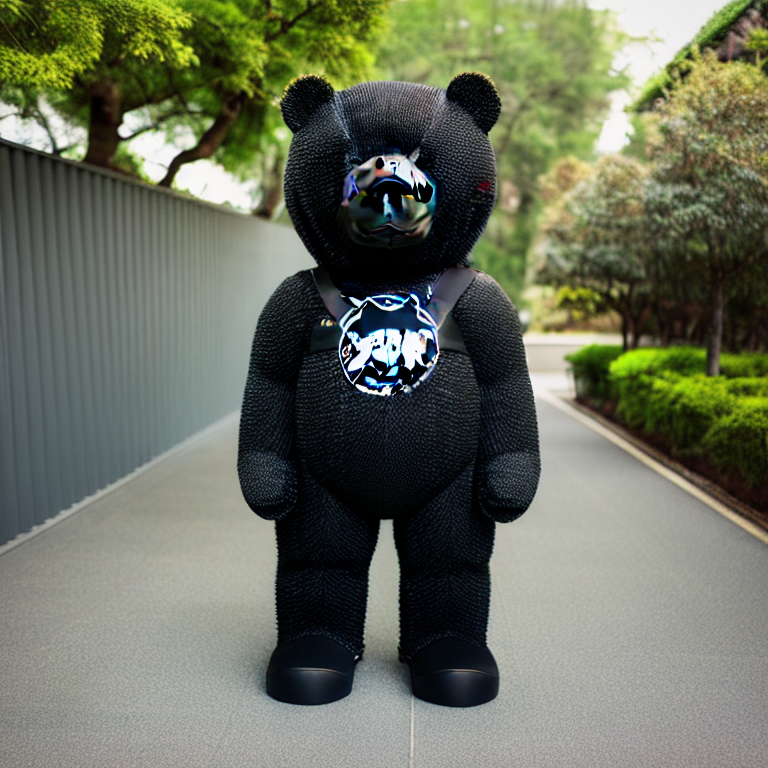
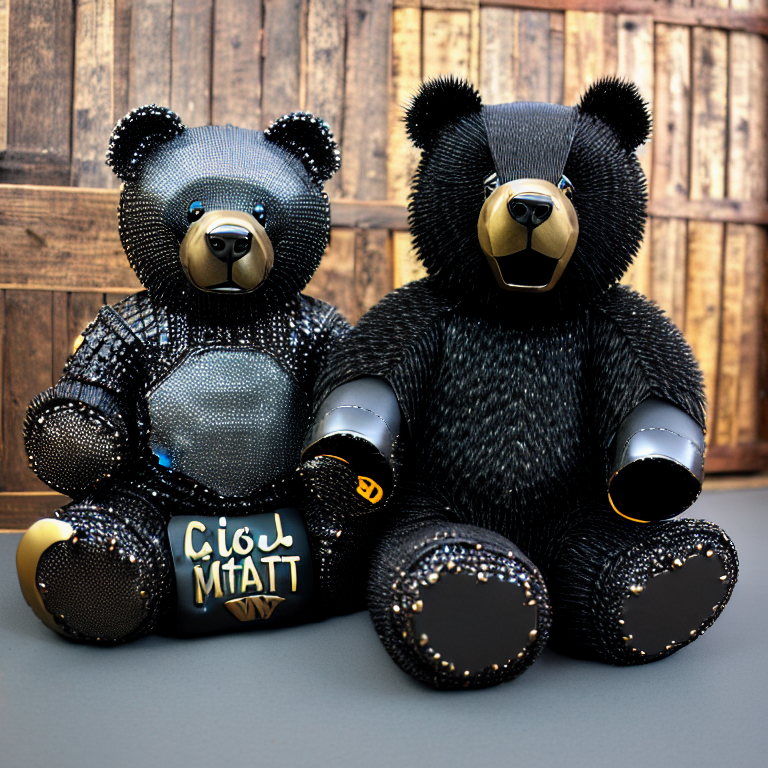

'Seed: 231121664'

In [ ]:
prompt = "black metalic bear"
remove_safety = False
num_images = 2
seed = random.randint(0, 2147483647)

if remove_safety:
  negative_prompt = None
  pipe.safety_checker = None
else:
  negative_prompt = "nude, naked" # None

images = pipe(
    prompt,
    height = image_length,
    width = image_length,
    num_inference_steps = 25,
    guidance_scale = 9,
    num_images_per_prompt = num_images,
    negative_prompt = negative_prompt,
    # generator = torch.Generator("cuda").manual_seed(seed)

    ).images

media.show_images(images)
display(f"Seed: {seed}")
# images[0].save("output.jpg")